In [1]:
import torch
print(torch.__version__)
import monai
print(monai.__version__)
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from ipywidgets.widgets import *
import ipywidgets as widgets

1.7.1
0.4.0


In [3]:
from dataset import DatasetStg1

TRAIN_PATH = '/scratch/mok232/Medical-Imaging/AnatomyNet-for-anatomical-segmentation/data/trainpddca15_crp_v2_pool1.pth'
TEST_PATH = '/scratch/mok232/Medical-Imaging/AnatomyNet-for-anatomical-segmentation/data/testpddca15_crp_v2_pool1.pth'
CET_PATH = '/scratch/mok232/Medical-Imaging/AnatomyNet-for-anatomical-segmentation/data/trainpddca15_cet_crp_v2_pool1.pth'
PET_PATH = '/scratch/mok232/Medical-Imaging/AnatomyNet-for-anatomical-segmentation/data/trainpddca15_pet_crp_v2_pool1.pth'

# traindataset = DatasetStg1(PET_PATH, istranform=True)
# traindataloader = t.utils.data.DataLoader(traindataset,num_workers=0,batch_size=1, shuffle=True)
testdataset = DatasetStg1(TEST_PATH, istranform=False)
testdataloader = torch.utils.data.DataLoader(testdataset,num_workers=0,batch_size=1)
# print(len(traindataloader), len(testdataloader))

In [4]:
image, one_hot_label, _ = testdataset[0]
print(image.shape, one_hot_label.shape)

torch.Size([1, 80, 200, 152]) torch.Size([10, 80, 200, 152])


In [5]:
print(image.min(), image.max())
print(one_hot_label.min(), one_hot_label.max())

tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


In [6]:
plt.rcParams["figure.figsize"] = (15,10)

@interact(cls=(0,one_hot_label.shape[0]-1), slc=(0,image.shape[1]-1))
def dicom_animation(cls, slc):
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(image[0,slc,:,:], cmap='gray')
    axs[0].set_title(f'CT (slice = {slc})')
    
    axs[1].imshow(one_hot_label[cls,slc,:,:], cmap='gray')
    axs[1].set_title(f'Label (slice = {slc}) (class = {cls})')
    return f"class = {cls}, slice = {slc}"

interactive(children=(IntSlider(value=4, description='cls', max=9), IntSlider(value=39, description='slc', max…

## Medical Image Transforms

In [7]:
from monai.transforms import RandAffined, Rand3DElasticd, RandSpatialCropd, RandFlipd, NormalizeIntensityd, RandScaleIntensityd, RandShiftIntensityd, ToTensord, RandZoomd, Resized, Compose
import time

In [8]:
data_dict = {"image":image, "label":one_hot_label}

### 1. Random Affine

transform time = 0.767s
orig image shape: torch.Size([1, 80, 200, 152])


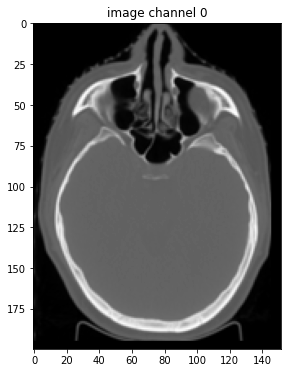

orig label shape: torch.Size([10, 80, 200, 152])


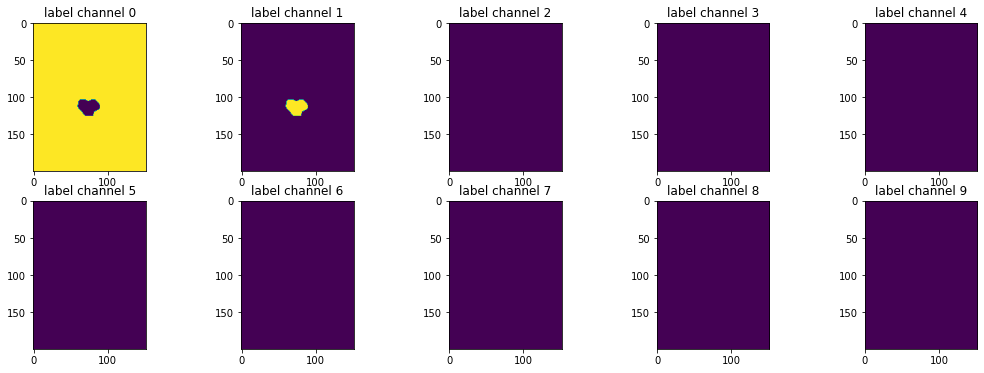

transformed image shape: torch.Size([1, 80, 200, 152])


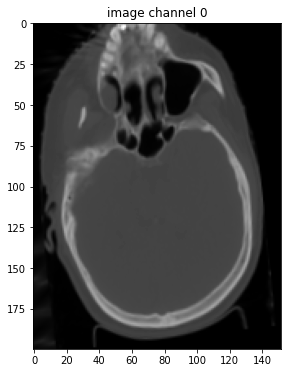

transformed label shape: torch.Size([10, 80, 200, 152])


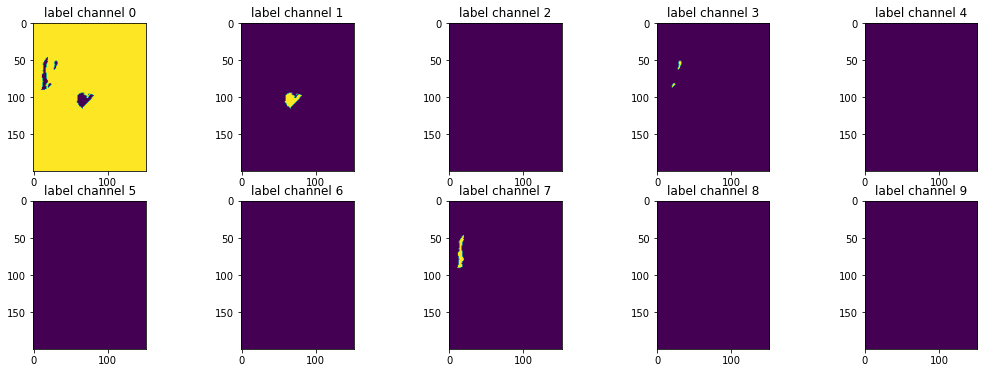

In [28]:
transform = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
#     spatial_size=(240, 240, 155),
    translate_range=(5, 15, 15),
    rotate_range=(np.pi / 18, np.pi / 18, np.pi / 18),
    scale_range=(0.1, 0.1, 0.1),
    padding_mode="border",
#     device=torch.device("cuda:0")
)

t1 = time.time()
transformed_data_dict = transform(data_dict)
print(f"transform time = {round(time.time()-t1,3)}s")

print(f"orig image shape: {data_dict['image'].shape}")
plt.figure("orig image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"orig label shape: {data_dict['label'].shape}")
plt.figure("orig label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(data_dict["label"][i, 40, :, :])
plt.show()


print(f"transformed image shape: {transformed_data_dict['image'].shape}")
plt.figure("transformed image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(transformed_data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"transformed label shape: {transformed_data_dict['label'].shape}")
plt.figure("transformed label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(transformed_data_dict["label"][i, 40, :, :])
plt.show()

In [16]:
plt.figure(dpi=600)
plt.imshow(data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/orig_affine.png")
plt.close()

plt.figure(dpi=600)
plt.imshow(transformed_data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/transformed_affine.png")
plt.close()

### 2. Random Elastic

transform time = 2.597s
orig image shape: torch.Size([1, 80, 200, 152])


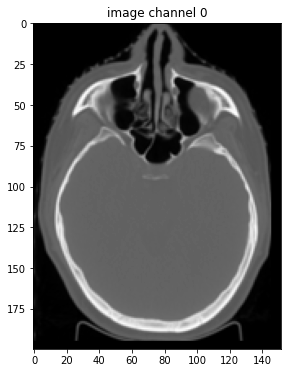

orig label shape: torch.Size([10, 80, 200, 152])


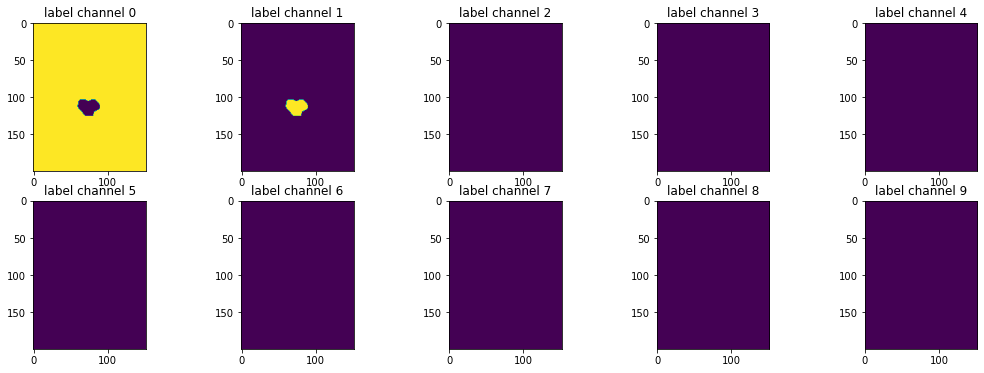

transformed image shape: (1, 80, 200, 152)


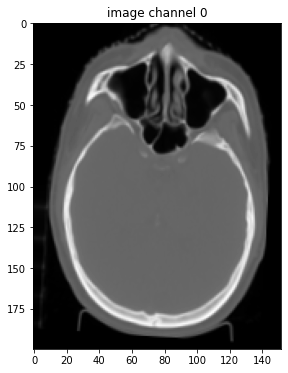

transformed label shape: (10, 80, 200, 152)


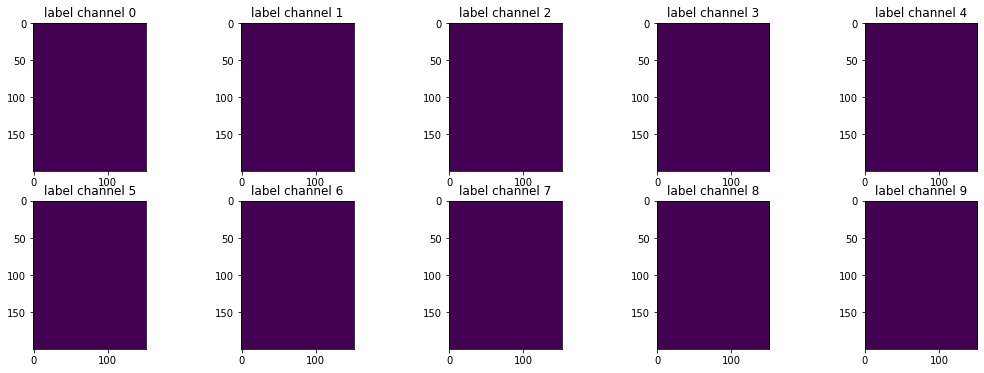

In [29]:
transform = Rand3DElasticd(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    sigma_range=(5, 8),
    magnitude_range=(10, 20),
#     spatial_size=(50, 50, 50),
    translate_range=(5, 15, 15),
    rotate_range=(np.pi / 18, np.pi / 18, np.pi/18),
    scale_range=(0.1, 0.1, 0.1),
    padding_mode="border",
)

t1 = time.time()
transformed_data_dict = transform(data_dict)
print(f"transform time = {round(time.time()-t1,3)}s")

print(f"orig image shape: {data_dict['image'].shape}")
plt.figure("orig image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"orig label shape: {data_dict['label'].shape}")
plt.figure("orig label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(data_dict["label"][i, 40, :, :])
plt.show()


print(f"transformed image shape: {transformed_data_dict['image'].shape}")
plt.figure("transformed image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(transformed_data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"transformed label shape: {transformed_data_dict['label'].shape}")
plt.figure("transformed label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(transformed_data_dict["label"][i, 40, :, :])
plt.show()

In [30]:
plt.figure(dpi=600)
plt.imshow(data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/orig_elastic.png")
plt.close()

plt.figure(dpi=600)
plt.imshow(transformed_data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/transformed_elastic.png")
plt.close()

### 3. RandSpatialCrop

transform time = 0.736s
orig image shape: torch.Size([1, 80, 200, 152])


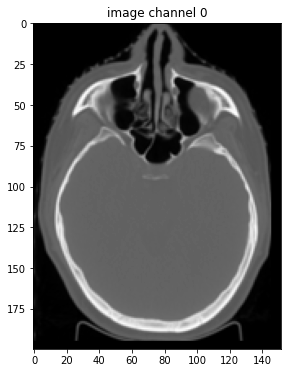

orig label shape: torch.Size([10, 80, 200, 152])


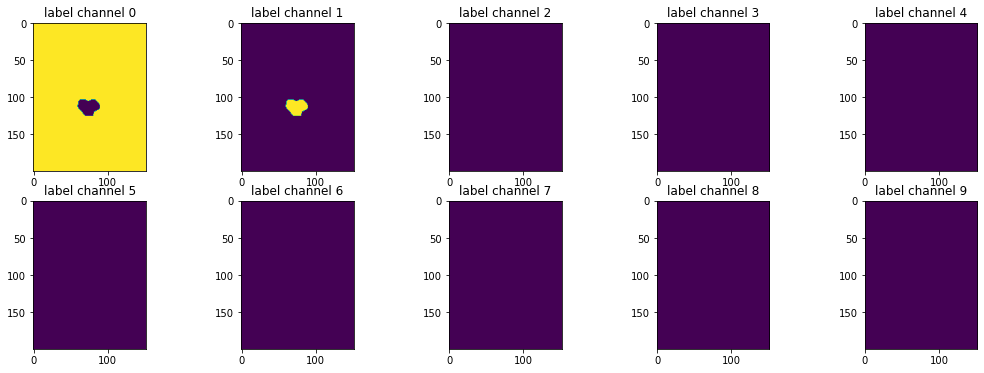

transformed image shape: (1, 80, 200, 152)


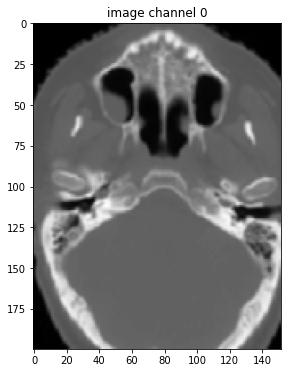

transformed label shape: (10, 80, 200, 152)


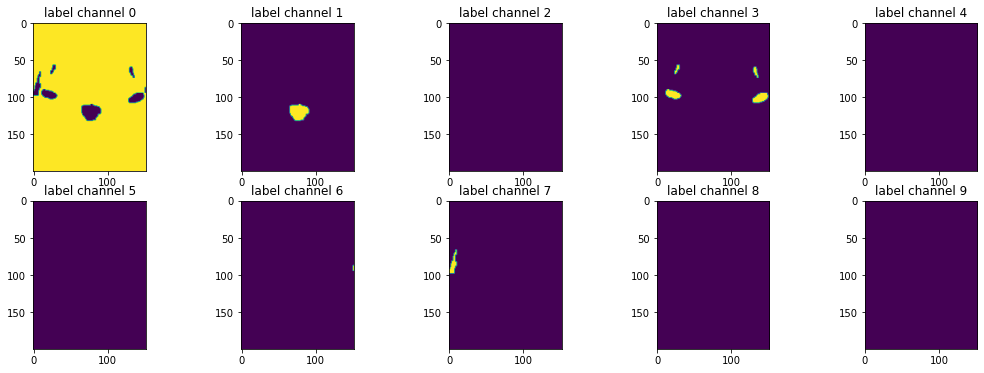

In [22]:
crop_factor = 0.9
size = [int(crop_factor*data_dict['image'].shape[1]), int(crop_factor*data_dict['image'].shape[2]), int(crop_factor*data_dict['image'].shape[3])]
transform = Compose([
    RandSpatialCropd(keys=["image", "label"], roi_size=size, random_size=False),
    Resized(keys=["image", "label"], spatial_size=(data_dict['image'].shape[1], data_dict['image'].shape[2], data_dict['image'].shape[3])),
]
)

t1 = time.time()
transformed_data_dict = transform(data_dict)
print(f"transform time = {round(time.time()-t1,3)}s")

print(f"orig image shape: {data_dict['image'].shape}")
plt.figure("orig image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"orig label shape: {data_dict['label'].shape}")
plt.figure("orig label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(data_dict["label"][i, 40, :, :])
plt.show()


print(f"transformed image shape: {transformed_data_dict['image'].shape}")
plt.figure("transformed image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(transformed_data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"transformed label shape: {transformed_data_dict['label'].shape}")
plt.figure("transformed label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(transformed_data_dict["label"][i, 40, :, :])
plt.show()

In [23]:
plt.figure(dpi=600)
plt.imshow(data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/orig_crop.png")
plt.close()

plt.figure(dpi=600)
plt.imshow(transformed_data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/transformed_crop.png")
plt.close()

### 4. RandZoom

transform time = 0.609s
orig image shape: torch.Size([1, 80, 200, 152])


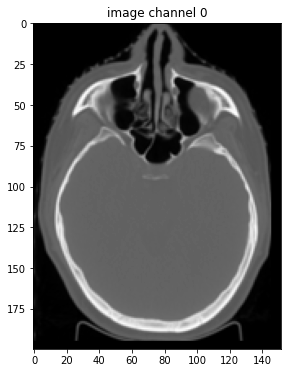

orig label shape: torch.Size([10, 80, 200, 152])


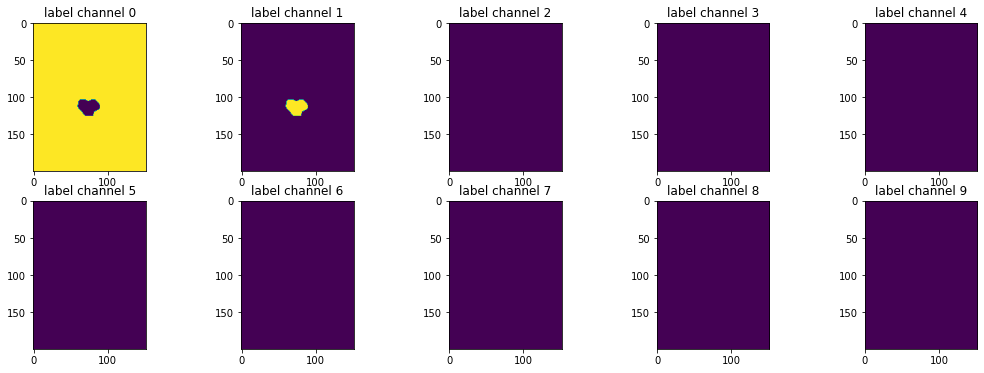

transformed image shape: (1, 80, 200, 152)


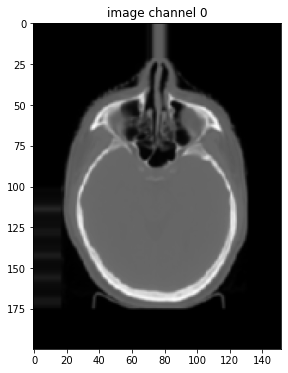

transformed label shape: (10, 80, 200, 152)


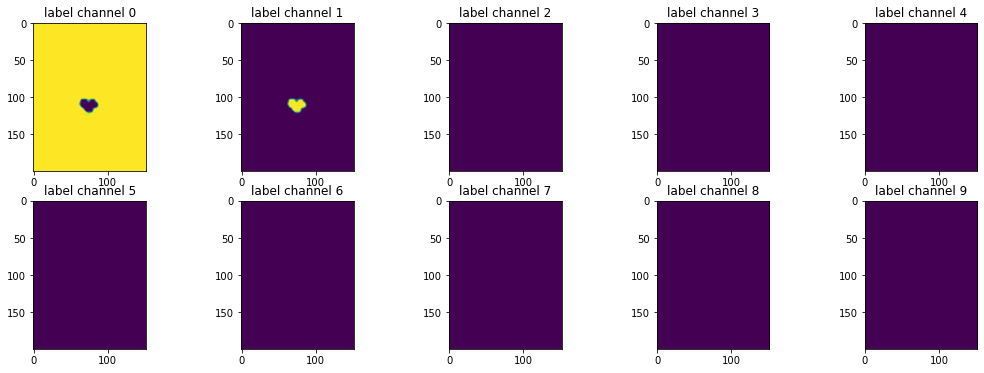

In [26]:
# transform = RandFlipd(keys=["image", "label"], prob=1.0, spatial_axis=0)
transform = RandZoomd(keys=["image", "label"], prob=1.0, min_zoom=0.8, max_zoom=1.2)


t1 = time.time()
transformed_data_dict = transform(data_dict)
print(f"transform time = {round(time.time()-t1,3)}s")

print(f"orig image shape: {data_dict['image'].shape}")
plt.figure("orig image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"orig label shape: {data_dict['label'].shape}")
plt.figure("orig label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(data_dict["label"][i, 40, :, :])
plt.show()


print(f"transformed image shape: {transformed_data_dict['image'].shape}")
plt.figure("transformed image", (24, 6))
for i in range(1):
    plt.subplot(1, 1, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(transformed_data_dict["image"][i, 40, :, :], cmap="gray")
plt.show()
# also visualize the 5 channels label corresponding to this image
print(f"transformed label shape: {transformed_data_dict['label'].shape}")
plt.figure("transformed label", (18, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(transformed_data_dict["label"][i, 40, :, :])
plt.show()

In [27]:
plt.figure(dpi=600)
plt.imshow(data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/orig_zoom.png")
plt.close()

plt.figure(dpi=600)
plt.imshow(transformed_data_dict["image"][0, 40, :, :], cmap="gray")
plt.savefig("augmentation_images/transformed_zoom.png")
plt.close()